<a href="https://colab.research.google.com/github/DOMINION-JOHN1/AI_ML_INTERN_ROADMAP/blob/main/fashion_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports** **of** **libraries**

In [3]:
# First, install the package
!pip install git+https://github.com/qubvel/classification_models.git

# Then, import the necessary modules
from classification_models.tfkeras import Classifiers




  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-h1noo1_o
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-h1noo1_o
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.0 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20028 sha256=f512d9551b44136496ab11e3cb1e04e5efb4e98b86652c9c3c7c29e2c9d10389
  Stored in directory: /tmp/pip-ephem-wheel-cache-6u3xg4jo/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image-classifiers


In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm
from tqdm.notebook import tqdm


**Loading of pretrained model**

In [5]:
# Get the ResNeXt model
ResNeXt50, preprocess_input = Classifiers.get('resnext50')

# Now, you can create a model instance
model = ResNeXt50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

94428600/94428600 [==============================] - 1s 0us/step


In [6]:
# Freeze the weights of the pre-trained layers

model.trainable = False

In [7]:
# Create a new model by adding layers on top of the pre-trained base
model = tensorflow.keras.Sequential([model, GlobalMaxPooling2D()])

# Print the model summary to see the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 2048)        23048137  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23048137 (87.92 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23048137 (87.92 MB)
_________________________________________________________________


**Loading of dataset from kaggle**

In [8]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small -p /content



 96% 545M/565M [00:03<00:00, 161MB/s]
100% 565M/565M [00:03<00:00, 154MB/s]


In [10]:
!unzip -q fashion-product-images-small.zip


**Feature** **extraction**

Number of images found: 44441
Image paths: ['/content/images/48910.jpg', '/content/images/26713.jpg', '/content/images/31242.jpg', '/content/images/28215.jpg', '/content/images/18873.jpg', '/content/images/25572.jpg', '/content/images/46246.jpg', '/content/images/50610.jpg', '/content/images/48676.jpg', '/content/images/6069.jpg', '/content/images/15988.jpg', '/content/images/49145.jpg', '/content/images/46036.jpg', '/content/images/13454.jpg', '/content/images/13536.jpg', '/content/images/9158.jpg', '/content/images/21424.jpg', '/content/images/9810.jpg', '/content/images/41236.jpg', '/content/images/45291.jpg', '/content/images/40464.jpg', '/content/images/47057.jpg', '/content/images/14803.jpg', '/content/images/27911.jpg', '/content/images/5396.jpg', '/content/images/48387.jpg', '/content/images/45772.jpg', '/content/images/22942.jpg', '/content/images/27663.jpg', '/content/images/37412.jpg', '/content/images/20247.jpg', '/content/images/16923.jpg', '/content/images/50852.jpg', '/c

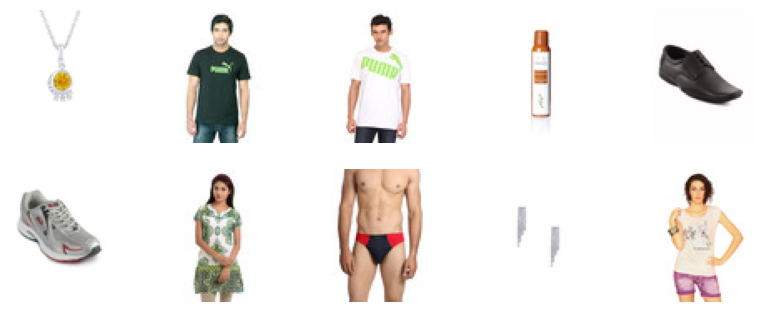

In [11]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
extracted_path = "/content/images"

img_dir = extracted_path

# Filter out non-image files
img_paths = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir) if img_file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Print debugging information
print("Number of images found:", len(img_paths))
print("Image paths:", img_paths)

plt.figure(1, figsize=(10, 10))

for i in range(10):
    img = mpimg.imread(img_paths[i])
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [12]:
def extract_features(img_path,model):
    img = image.load_img(img_path,target_size=(224,224))
    img_array=image.img_to_array(img)
    expanded_img_array=np.expand_dims(img_array,axis=0)
    preprocessed_img=preprocess_input(expanded_img_array)
    result=model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)

    return normalized_result

In [13]:
filenames = []
for file in os.listdir("/content/images"):
    filenames.append(os.path.join("/content/images",file))

In [14]:
filenames[:5]

['/content/images/48910.jpg',
 '/content/images/26713.jpg',
 '/content/images/31242.jpg',
 '/content/images/28215.jpg',
 '/content/images/18873.jpg']

In [15]:
from tqdm import tqdm

# Define a function to process a batch of files
def extract_features_batch(files, model):
    batch_features = []
    for file in files:
        batch_features.append(extract_features(file, model))
    return batch_features

# Initialize an empty list to store features
feature_list = []

# Process files in batches
batch_size = 150  # You can adjust this value based on your memory constraints
for i in tqdm(range(0, len(filenames), batch_size)):
    batch_files = filenames[i:i+batch_size]
    batch_features = extract_features_batch(batch_files, model)
    feature_list.extend(batch_features)


  0%|          | 0/297 [00:00<?, ?it/s]

1/1 [==============================] - 0s 73ms/step


  0%|          | 1/297 [00:30<2:31:14, 30.66s/it]

1/1 [==============================] - 0s 71ms/step


  1%|          | 2/297 [00:51<2:01:41, 24.75s/it]

1/1 [==============================] - 0s 79ms/step


  1%|          | 3/297 [01:12<1:52:32, 22.97s/it]

1/1 [==============================] - 0s 86ms/step


  1%|▏         | 4/297 [01:34<1:51:29, 22.83s/it]

1/1 [==============================] - 0s 86ms/step


  2%|▏         | 5/297 [01:55<1:48:08, 22.22s/it]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 6/297 [02:16<1:45:45, 21.81s/it]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 7/297 [02:38<1:44:50, 21.69s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 8/297 [03:00<1:44:51, 21.77s/it]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 9/297 [03:21<1:43:02, 21.47s/it]

1/1 [==============================] - 0s 49ms/step


  3%|▎         | 10/297 [03:41<1:41:41, 21.26s/it]

1/1 [==============================] - 0s 52ms/step


  4%|▎         | 11/297 [04:02<1:40:09, 21.01s/it]

1/1 [==============================] - 0s 56ms/step


  4%|▍         | 12/297 [04:23<1:40:16, 21.11s/it]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 13/297 [04:44<1:38:54, 20.90s/it]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 14/297 [05:04<1:37:48, 20.74s/it]

1/1 [==============================] - 0s 65ms/step


  5%|▌         | 15/297 [05:25<1:38:18, 20.92s/it]

1/1 [==============================] - 0s 85ms/step


  5%|▌         | 16/297 [05:48<1:40:06, 21.38s/it]

1/1 [==============================] - 0s 73ms/step


  6%|▌         | 17/297 [06:09<1:39:30, 21.32s/it]

1/1 [==============================] - 0s 88ms/step


  6%|▌         | 18/297 [06:31<1:39:41, 21.44s/it]

1/1 [==============================] - 0s 74ms/step


  6%|▋         | 19/297 [06:52<1:39:30, 21.48s/it]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 20/297 [07:14<1:39:50, 21.63s/it]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 21/297 [07:35<1:38:38, 21.45s/it]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 22/297 [07:55<1:36:42, 21.10s/it]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 23/297 [08:16<1:35:48, 20.98s/it]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 24/297 [08:38<1:37:12, 21.37s/it]

1/1 [==============================] - 0s 50ms/step


  8%|▊         | 25/297 [08:59<1:35:52, 21.15s/it]

1/1 [==============================] - 0s 51ms/step


  9%|▉         | 26/297 [09:19<1:34:13, 20.86s/it]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 27/297 [09:40<1:33:12, 20.71s/it]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 28/297 [10:02<1:34:26, 21.06s/it]

1/1 [==============================] - 0s 51ms/step


 10%|▉         | 29/297 [10:22<1:33:43, 20.98s/it]

1/1 [==============================] - 0s 90ms/step


 10%|█         | 30/297 [10:43<1:32:47, 20.85s/it]

1/1 [==============================] - 0s 80ms/step


 10%|█         | 31/297 [11:05<1:34:15, 21.26s/it]

1/1 [==============================] - 0s 75ms/step


 11%|█         | 32/297 [11:28<1:35:41, 21.67s/it]

1/1 [==============================] - 0s 77ms/step


 11%|█         | 33/297 [11:48<1:33:53, 21.34s/it]

1/1 [==============================] - 0s 84ms/step


 11%|█▏        | 34/297 [12:09<1:32:52, 21.19s/it]

1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 35/297 [12:30<1:31:53, 21.04s/it]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 36/297 [12:51<1:32:09, 21.18s/it]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 37/297 [13:12<1:30:50, 20.96s/it]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 38/297 [13:32<1:29:56, 20.84s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 39/297 [13:54<1:30:29, 21.04s/it]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 40/297 [14:15<1:30:49, 21.20s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 41/297 [14:36<1:29:51, 21.06s/it]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 42/297 [14:57<1:29:05, 20.96s/it]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 43/297 [15:18<1:29:14, 21.08s/it]

1/1 [==============================] - 0s 77ms/step


 15%|█▍        | 44/297 [15:40<1:29:08, 21.14s/it]

1/1 [==============================] - 0s 70ms/step


 15%|█▌        | 45/297 [16:01<1:29:04, 21.21s/it]

1/1 [==============================] - 0s 95ms/step


 15%|█▌        | 46/297 [16:22<1:29:07, 21.30s/it]

1/1 [==============================] - 0s 87ms/step


 16%|█▌        | 47/297 [16:45<1:30:51, 21.81s/it]

1/1 [==============================] - 0s 78ms/step


 16%|█▌        | 48/297 [17:07<1:30:01, 21.69s/it]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 49/297 [17:28<1:29:03, 21.54s/it]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 50/297 [17:49<1:28:08, 21.41s/it]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 51/297 [18:12<1:29:02, 21.72s/it]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 52/297 [18:32<1:27:27, 21.42s/it]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 53/297 [18:54<1:26:54, 21.37s/it]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 54/297 [19:16<1:27:26, 21.59s/it]

1/1 [==============================] - 0s 49ms/step


 19%|█▊        | 55/297 [19:40<1:29:57, 22.30s/it]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 56/297 [20:01<1:28:48, 22.11s/it]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 57/297 [20:23<1:27:52, 21.97s/it]

1/1 [==============================] - 0s 76ms/step


 20%|█▉        | 58/297 [20:46<1:28:23, 22.19s/it]

1/1 [==============================] - 0s 76ms/step


 20%|█▉        | 59/297 [21:10<1:31:03, 22.95s/it]

1/1 [==============================] - 0s 83ms/step


 20%|██        | 60/297 [21:33<1:30:09, 22.82s/it]

1/1 [==============================] - 0s 74ms/step


 21%|██        | 61/297 [21:55<1:28:49, 22.58s/it]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 62/297 [22:20<1:30:52, 23.20s/it]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 63/297 [22:41<1:28:39, 22.73s/it]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 64/297 [23:02<1:26:36, 22.30s/it]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 65/297 [23:24<1:25:13, 22.04s/it]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 66/297 [23:47<1:26:13, 22.39s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 67/297 [24:08<1:24:18, 21.99s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 68/297 [24:29<1:22:49, 21.70s/it]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 69/297 [24:50<1:21:42, 21.50s/it]

1/1 [==============================] - 0s 71ms/step


 24%|██▎       | 70/297 [25:15<1:24:42, 22.39s/it]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 71/297 [25:36<1:23:31, 22.18s/it]

1/1 [==============================] - 0s 75ms/step


 24%|██▍       | 72/297 [25:58<1:23:05, 22.16s/it]

1/1 [==============================] - 0s 108ms/step


 25%|██▍       | 73/297 [26:22<1:24:22, 22.60s/it]

1/1 [==============================] - 0s 72ms/step


 25%|██▍       | 74/297 [26:45<1:24:01, 22.61s/it]

1/1 [==============================] - 0s 63ms/step


 25%|██▌       | 75/297 [27:06<1:22:39, 22.34s/it]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 76/297 [27:27<1:20:44, 21.92s/it]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 77/297 [27:51<1:22:30, 22.50s/it]

1/1 [==============================] - 0s 55ms/step


 26%|██▋       | 78/297 [28:14<1:22:17, 22.55s/it]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 79/297 [28:36<1:21:24, 22.41s/it]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 80/297 [28:58<1:20:32, 22.27s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 81/297 [29:22<1:22:01, 22.78s/it]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 82/297 [29:44<1:20:23, 22.44s/it]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 83/297 [30:05<1:19:18, 22.23s/it]

1/1 [==============================] - 0s 69ms/step


 28%|██▊       | 84/297 [30:27<1:18:12, 22.03s/it]

1/1 [==============================] - 0s 75ms/step


 29%|██▊       | 85/297 [30:51<1:20:28, 22.78s/it]

1/1 [==============================] - 0s 79ms/step


 29%|██▉       | 86/297 [31:15<1:20:41, 22.95s/it]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 87/297 [31:37<1:19:35, 22.74s/it]

1/1 [==============================] - 0s 73ms/step


 30%|██▉       | 88/297 [32:00<1:19:02, 22.69s/it]

1/1 [==============================] - 0s 82ms/step


 30%|██▉       | 89/297 [32:22<1:18:14, 22.57s/it]

1/1 [==============================] - 0s 82ms/step


 30%|███       | 90/297 [32:44<1:17:16, 22.40s/it]

1/1 [==============================] - 0s 53ms/step


 31%|███       | 91/297 [33:06<1:16:22, 22.24s/it]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 92/297 [33:29<1:17:33, 22.70s/it]

1/1 [==============================] - 0s 52ms/step


 31%|███▏      | 93/297 [33:52<1:16:44, 22.57s/it]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 94/297 [34:14<1:16:10, 22.52s/it]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 95/297 [34:36<1:15:03, 22.30s/it]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 96/297 [35:00<1:16:00, 22.69s/it]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 97/297 [35:21<1:14:22, 22.31s/it]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 98/297 [35:42<1:13:00, 22.01s/it]

1/1 [==============================] - 0s 92ms/step


 33%|███▎      | 99/297 [36:04<1:12:26, 21.95s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███▎      | 100/297 [36:27<1:13:03, 22.25s/it]

1/1 [==============================] - 0s 90ms/step


 34%|███▍      | 101/297 [36:51<1:14:09, 22.70s/it]

1/1 [==============================] - 0s 81ms/step


 34%|███▍      | 102/297 [37:14<1:14:34, 22.94s/it]

1/1 [==============================] - 0s 92ms/step


 35%|███▍      | 103/297 [37:39<1:15:44, 23.43s/it]

1/1 [==============================] - 0s 71ms/step


 35%|███▌      | 104/297 [38:01<1:14:23, 23.13s/it]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 105/297 [38:23<1:12:37, 22.69s/it]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 106/297 [38:44<1:11:02, 22.32s/it]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 107/297 [39:08<1:11:49, 22.68s/it]

1/1 [==============================] - 0s 50ms/step


 36%|███▋      | 108/297 [39:29<1:10:17, 22.31s/it]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 109/297 [39:52<1:10:28, 22.49s/it]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 110/297 [40:14<1:09:46, 22.39s/it]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 111/297 [40:39<1:11:13, 22.98s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 112/297 [41:01<1:09:42, 22.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 113/297 [41:22<1:08:39, 22.39s/it]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 114/297 [41:45<1:08:47, 22.56s/it]

1/1 [==============================] - 0s 64ms/step


 39%|███▊      | 115/297 [42:08<1:08:37, 22.63s/it]

1/1 [==============================] - 0s 70ms/step


 39%|███▉      | 116/297 [42:30<1:07:25, 22.35s/it]

1/1 [==============================] - 0s 83ms/step


 39%|███▉      | 117/297 [42:54<1:08:49, 22.94s/it]

1/1 [==============================] - 0s 89ms/step


 40%|███▉      | 118/297 [43:20<1:10:48, 23.74s/it]

1/1 [==============================] - 0s 78ms/step


 40%|████      | 119/297 [43:43<1:09:39, 23.48s/it]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 120/297 [44:05<1:07:58, 23.04s/it]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 121/297 [44:27<1:06:50, 22.79s/it]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 122/297 [44:51<1:07:43, 23.22s/it]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 123/297 [45:13<1:06:05, 22.79s/it]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 124/297 [45:35<1:05:21, 22.67s/it]

1/1 [==============================] - 0s 86ms/step


 42%|████▏     | 125/297 [46:00<1:06:41, 23.26s/it]

1/1 [==============================] - 0s 81ms/step


 42%|████▏     | 126/297 [46:25<1:07:48, 23.79s/it]

1/1 [==============================] - 0s 85ms/step


 43%|████▎     | 127/297 [46:48<1:07:04, 23.67s/it]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 128/297 [47:12<1:06:14, 23.52s/it]

1/1 [==============================] - 0s 82ms/step


 43%|████▎     | 129/297 [47:36<1:06:40, 23.81s/it]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 130/297 [47:58<1:04:45, 23.27s/it]

1/1 [==============================] - 0s 48ms/step


 44%|████▍     | 131/297 [48:20<1:03:02, 22.78s/it]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 132/297 [48:42<1:02:21, 22.68s/it]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 133/297 [49:08<1:04:25, 23.57s/it]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 134/297 [49:31<1:03:33, 23.40s/it]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 135/297 [49:53<1:02:16, 23.06s/it]

1/1 [==============================] - 0s 90ms/step


 46%|████▌     | 136/297 [50:18<1:03:05, 23.51s/it]

1/1 [==============================] - 0s 80ms/step


 46%|████▌     | 137/297 [50:40<1:01:49, 23.18s/it]

1/1 [==============================] - 0s 73ms/step


 46%|████▋     | 138/297 [51:03<1:00:55, 22.99s/it]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 139/297 [51:25<59:48, 22.71s/it]  

1/1 [==============================] - 0s 76ms/step


 47%|████▋     | 140/297 [51:50<1:01:51, 23.64s/it]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 141/297 [52:14<1:01:15, 23.56s/it]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 142/297 [52:37<1:00:23, 23.38s/it]

1/1 [==============================] - 0s 69ms/step


 48%|████▊     | 143/297 [53:00<59:49, 23.31s/it]  

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 144/297 [53:24<59:54, 23.49s/it]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 145/297 [53:46<58:18, 23.02s/it]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 146/297 [54:07<56:59, 22.65s/it]

1/1 [==============================] - 0s 101ms/step


 49%|████▉     | 147/297 [54:32<58:04, 23.23s/it]

1/1 [==============================] - 0s 85ms/step


 50%|████▉     | 148/297 [54:56<58:22, 23.50s/it]

1/1 [==============================] - 0s 83ms/step


 50%|█████     | 149/297 [55:20<58:23, 23.67s/it]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 150/297 [55:44<57:44, 23.57s/it]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 151/297 [56:09<58:26, 24.02s/it]

1/1 [==============================] - 0s 50ms/step


 51%|█████     | 152/297 [56:31<56:49, 23.51s/it]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 153/297 [56:53<55:35, 23.16s/it]

1/1 [==============================] - 0s 77ms/step


 52%|█████▏    | 154/297 [57:17<55:25, 23.25s/it]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 155/297 [57:40<55:17, 23.36s/it]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 156/297 [58:04<55:18, 23.54s/it]

1/1 [==============================] - 0s 80ms/step


 53%|█████▎    | 157/297 [58:29<55:21, 23.73s/it]

1/1 [==============================] - 0s 80ms/step


 53%|█████▎    | 158/297 [58:56<57:17, 24.73s/it]

1/1 [==============================] - 0s 74ms/step


 54%|█████▎    | 159/297 [59:19<55:51, 24.29s/it]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 160/297 [59:42<54:20, 23.80s/it]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 161/297 [1:00:04<53:02, 23.40s/it]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 162/297 [1:00:29<53:44, 23.89s/it]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 163/297 [1:00:51<52:16, 23.40s/it]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 164/297 [1:01:15<52:11, 23.55s/it]

1/1 [==============================] - 0s 81ms/step


 56%|█████▌    | 165/297 [1:01:42<54:03, 24.57s/it]

1/1 [==============================] - 0s 80ms/step


 56%|█████▌    | 166/297 [1:02:06<53:24, 24.46s/it]

1/1 [==============================] - 0s 77ms/step


 56%|█████▌    | 167/297 [1:02:30<52:21, 24.17s/it]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 168/297 [1:02:53<51:07, 23.78s/it]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 169/297 [1:03:18<51:26, 24.11s/it]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 170/297 [1:03:40<49:46, 23.51s/it]

1/1 [==============================] - 0s 54ms/step


 58%|█████▊    | 171/297 [1:04:02<48:38, 23.16s/it]

1/1 [==============================] - 0s 72ms/step


 58%|█████▊    | 172/297 [1:04:27<49:21, 23.69s/it]

1/1 [==============================] - 0s 76ms/step


 58%|█████▊    | 173/297 [1:04:52<49:49, 24.11s/it]

1/1 [==============================] - 0s 79ms/step


 59%|█████▊    | 174/297 [1:05:16<49:30, 24.15s/it]

1/1 [==============================] - 0s 86ms/step


 59%|█████▉    | 175/297 [1:05:40<48:49, 24.01s/it]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 176/297 [1:06:07<49:58, 24.78s/it]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 177/297 [1:06:29<48:24, 24.21s/it]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 178/297 [1:06:52<47:04, 23.74s/it]

1/1 [==============================] - 0s 89ms/step


 60%|██████    | 179/297 [1:07:16<46:52, 23.84s/it]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 180/297 [1:07:42<47:30, 24.36s/it]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 181/297 [1:08:05<46:36, 24.11s/it]

1/1 [==============================] - 0s 69ms/step


 61%|██████▏   | 182/297 [1:08:29<45:47, 23.89s/it]

1/1 [==============================] - 0s 96ms/step


 62%|██████▏   | 183/297 [1:08:55<47:03, 24.77s/it]

1/1 [==============================] - 0s 94ms/step


 62%|██████▏   | 184/297 [1:09:19<45:49, 24.33s/it]

1/1 [==============================] - 0s 69ms/step


 62%|██████▏   | 185/297 [1:09:42<44:39, 23.92s/it]

1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 186/297 [1:10:05<43:43, 23.63s/it]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 187/297 [1:10:32<45:12, 24.65s/it]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 188/297 [1:10:55<44:16, 24.37s/it]

1/1 [==============================] - 0s 54ms/step


 64%|██████▎   | 189/297 [1:11:19<43:17, 24.05s/it]

1/1 [==============================] - 0s 89ms/step


 64%|██████▍   | 190/297 [1:11:45<43:58, 24.66s/it]

1/1 [==============================] - 0s 84ms/step


 64%|██████▍   | 191/297 [1:12:08<42:54, 24.29s/it]

1/1 [==============================] - 0s 77ms/step


 65%|██████▍   | 192/297 [1:12:31<41:57, 23.98s/it]

1/1 [==============================] - 0s 80ms/step


 65%|██████▍   | 193/297 [1:12:54<41:02, 23.67s/it]

1/1 [==============================] - 0s 68ms/step


 65%|██████▌   | 194/297 [1:13:22<42:40, 24.86s/it]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 195/297 [1:13:46<41:44, 24.55s/it]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 196/297 [1:14:09<40:48, 24.25s/it]

1/1 [==============================] - 0s 94ms/step


 66%|██████▋   | 197/297 [1:14:35<41:01, 24.62s/it]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 198/297 [1:14:59<40:13, 24.38s/it]

1/1 [==============================] - 0s 67ms/step


 67%|██████▋   | 199/297 [1:15:22<39:10, 23.98s/it]

1/1 [==============================] - 0s 75ms/step


 67%|██████▋   | 200/297 [1:15:45<38:26, 23.78s/it]

1/1 [==============================] - 0s 73ms/step


 68%|██████▊   | 201/297 [1:16:12<39:33, 24.72s/it]

1/1 [==============================] - 0s 87ms/step


 68%|██████▊   | 202/297 [1:16:37<39:07, 24.71s/it]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 203/297 [1:17:01<38:26, 24.54s/it]

1/1 [==============================] - 0s 72ms/step


 69%|██████▊   | 204/297 [1:17:26<38:28, 24.82s/it]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 205/297 [1:17:51<38:12, 24.91s/it]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 206/297 [1:18:15<36:55, 24.35s/it]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 207/297 [1:18:37<35:48, 23.88s/it]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 208/297 [1:19:04<36:36, 24.68s/it]

1/1 [==============================] - 0s 69ms/step


 70%|███████   | 209/297 [1:19:27<35:43, 24.36s/it]

1/1 [==============================] - 0s 107ms/step


 71%|███████   | 210/297 [1:19:52<35:31, 24.50s/it]

1/1 [==============================] - 0s 78ms/step


 71%|███████   | 211/297 [1:20:19<36:01, 25.13s/it]

1/1 [==============================] - 0s 85ms/step


 71%|███████▏  | 212/297 [1:20:47<36:55, 26.07s/it]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 213/297 [1:21:13<36:21, 25.96s/it]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 214/297 [1:21:37<35:02, 25.33s/it]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 215/297 [1:22:04<35:31, 25.99s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 216/297 [1:22:29<34:31, 25.58s/it]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 217/297 [1:22:53<33:25, 25.07s/it]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 218/297 [1:23:18<32:58, 25.05s/it]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 219/297 [1:23:44<32:54, 25.32s/it]

1/1 [==============================] - 0s 103ms/step


 74%|███████▍  | 220/297 [1:24:08<32:16, 25.15s/it]

1/1 [==============================] - 0s 79ms/step


 74%|███████▍  | 221/297 [1:24:34<31:56, 25.21s/it]

1/1 [==============================] - 0s 101ms/step


 75%|███████▍  | 222/297 [1:25:03<32:59, 26.39s/it]

1/1 [==============================] - 0s 74ms/step


 75%|███████▌  | 223/297 [1:25:28<31:58, 25.92s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 224/297 [1:25:52<30:45, 25.29s/it]

1/1 [==============================] - 0s 74ms/step


 76%|███████▌  | 225/297 [1:26:17<30:18, 25.25s/it]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 226/297 [1:26:43<30:05, 25.44s/it]

1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 227/297 [1:27:07<29:25, 25.23s/it]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 228/297 [1:27:32<28:43, 24.99s/it]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 229/297 [1:28:00<29:33, 26.08s/it]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 230/297 [1:28:24<28:20, 25.38s/it]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 231/297 [1:28:48<27:21, 24.88s/it]

1/1 [==============================] - 0s 126ms/step


 78%|███████▊  | 232/297 [1:29:15<27:47, 25.65s/it]

1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 233/297 [1:29:39<26:52, 25.20s/it]

1/1 [==============================] - 0s 81ms/step


 79%|███████▉  | 234/297 [1:30:04<26:21, 25.11s/it]

1/1 [==============================] - 0s 81ms/step


 79%|███████▉  | 235/297 [1:30:30<25:58, 25.14s/it]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 236/297 [1:30:59<26:49, 26.38s/it]

1/1 [==============================] - 0s 52ms/step


 80%|███████▉  | 237/297 [1:31:23<25:44, 25.74s/it]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 238/297 [1:31:47<24:40, 25.09s/it]

1/1 [==============================] - 0s 69ms/step


 80%|████████  | 239/297 [1:32:14<24:48, 25.67s/it]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 240/297 [1:32:38<24:04, 25.34s/it]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 241/297 [1:33:02<23:08, 24.79s/it]

1/1 [==============================] - 0s 71ms/step


 81%|████████▏ | 242/297 [1:33:26<22:27, 24.49s/it]

1/1 [==============================] - 0s 74ms/step


 82%|████████▏ | 243/297 [1:33:55<23:18, 25.91s/it]

1/1 [==============================] - 0s 80ms/step


 82%|████████▏ | 244/297 [1:34:20<22:48, 25.82s/it]

1/1 [==============================] - 0s 81ms/step


 82%|████████▏ | 245/297 [1:34:46<22:15, 25.69s/it]

1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 246/297 [1:35:14<22:35, 26.58s/it]

1/1 [==============================] - 0s 113ms/step


 83%|████████▎ | 247/297 [1:35:40<21:49, 26.20s/it]

1/1 [==============================] - 0s 76ms/step


 84%|████████▎ | 248/297 [1:36:04<20:58, 25.68s/it]

1/1 [==============================] - 0s 79ms/step


 84%|████████▍ | 249/297 [1:36:30<20:31, 25.66s/it]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 250/297 [1:36:57<20:30, 26.17s/it]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 251/297 [1:37:22<19:41, 25.68s/it]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 252/297 [1:37:46<18:58, 25.30s/it]

1/1 [==============================] - 0s 79ms/step


 85%|████████▌ | 253/297 [1:38:15<19:20, 26.37s/it]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 254/297 [1:38:39<18:20, 25.59s/it]

1/1 [==============================] - 0s 94ms/step


 86%|████████▌ | 255/297 [1:39:03<17:34, 25.10s/it]

1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 256/297 [1:39:28<17:12, 25.18s/it]

1/1 [==============================] - 0s 84ms/step


 87%|████████▋ | 257/297 [1:39:54<17:01, 25.54s/it]

1/1 [==============================] - 0s 107ms/step


 87%|████████▋ | 258/297 [1:40:19<16:29, 25.36s/it]

1/1 [==============================] - 0s 83ms/step


 87%|████████▋ | 259/297 [1:40:45<16:07, 25.45s/it]

1/1 [==============================] - 0s 68ms/step


 88%|████████▊ | 260/297 [1:41:15<16:35, 26.89s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 261/297 [1:41:40<15:43, 26.22s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 262/297 [1:42:04<14:52, 25.50s/it]

1/1 [==============================] - 0s 74ms/step


 89%|████████▊ | 263/297 [1:42:29<14:27, 25.51s/it]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 264/297 [1:42:56<14:10, 25.77s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 265/297 [1:43:19<13:20, 25.01s/it]

1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 266/297 [1:43:44<12:52, 24.91s/it]

1/1 [==============================] - 0s 114ms/step


 90%|████████▉ | 267/297 [1:44:14<13:16, 26.54s/it]

1/1 [==============================] - 0s 108ms/step


 90%|█████████ | 268/297 [1:44:39<12:41, 26.24s/it]

1/1 [==============================] - 0s 78ms/step


 91%|█████████ | 269/297 [1:45:04<12:01, 25.78s/it]

1/1 [==============================] - 0s 105ms/step


 91%|█████████ | 270/297 [1:45:30<11:36, 25.78s/it]

1/1 [==============================] - 0s 85ms/step


 91%|█████████ | 271/297 [1:45:58<11:25, 26.38s/it]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 272/297 [1:46:21<10:39, 25.59s/it]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 273/297 [1:46:46<10:03, 25.14s/it]

1/1 [==============================] - 0s 80ms/step


 92%|█████████▏| 274/297 [1:47:15<10:08, 26.46s/it]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 275/297 [1:47:41<09:35, 26.15s/it]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 276/297 [1:48:05<08:58, 25.63s/it]

1/1 [==============================] - 0s 101ms/step


 93%|█████████▎| 277/297 [1:48:32<08:39, 25.97s/it]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▎| 278/297 [1:48:58<08:17, 26.20s/it]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 279/297 [1:49:23<07:40, 25.60s/it]

1/1 [==============================] - 0s 84ms/step


 94%|█████████▍| 280/297 [1:49:47<07:08, 25.22s/it]

1/1 [==============================] - 0s 85ms/step


 95%|█████████▍| 281/297 [1:50:16<07:01, 26.36s/it]

1/1 [==============================] - 0s 77ms/step


 95%|█████████▍| 282/297 [1:50:42<06:34, 26.29s/it]

1/1 [==============================] - 0s 80ms/step


 95%|█████████▌| 283/297 [1:51:08<06:07, 26.22s/it]

1/1 [==============================] - 0s 84ms/step


 96%|█████████▌| 284/297 [1:51:34<05:40, 26.20s/it]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▌| 285/297 [1:52:03<05:22, 26.86s/it]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 286/297 [1:52:27<04:46, 26.06s/it]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 287/297 [1:52:51<04:14, 25.44s/it]

1/1 [==============================] - 0s 98ms/step


 97%|█████████▋| 288/297 [1:53:20<03:57, 26.40s/it]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 289/297 [1:53:44<03:27, 25.90s/it]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 290/297 [1:54:09<02:58, 25.50s/it]

1/1 [==============================] - 0s 110ms/step


 98%|█████████▊| 291/297 [1:54:37<02:37, 26.17s/it]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 292/297 [1:55:04<02:13, 26.65s/it]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▊| 293/297 [1:55:30<01:44, 26.22s/it]

1/1 [==============================] - 0s 87ms/step


 99%|█████████▉| 294/297 [1:55:55<01:17, 25.87s/it]

1/1 [==============================] - 0s 74ms/step


 99%|█████████▉| 295/297 [1:56:24<00:53, 26.89s/it]

1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 296/297 [1:56:49<00:26, 26.37s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 297/297 [1:56:57<00:00, 23.63s/it]


In [21]:
import pickle



# Saving feature_list to 'embeddings.pkl' in a specific directory
pickle.dump(feature_list, open('/content/embeddings.pkl', 'wb'))

# Saving filenames to 'filenames.pkl' in a specific directory
pickle.dump(filenames, open('/content/filenames.pkl', 'wb'))



In [22]:
import os

# List the contents of the current directory
print(os.listdir('/content'))


['.config', 'images', 'embeddings.pkl', 'fashion-product-images-small.zip', 'filenames.pkl', 'myntradataset', 'styles.csv', 'sample_data']


In [23]:
from google.colab import files

# Download embeddings.pkl
files.download('/content/embeddings.pkl')

# Download filenames.pkl
files.download('/content/filenames.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>